# How to Structure from Motion

## Authors: Muneeb Aadil, Sibt Ul Hussain

In [108]:
#loading needed libraries 
import utils as ut 
import SfM as sfmnp

import matplotlib.pyplot as plt 

from mpl_toolkits.mplot3d import Axes3D

import cv2 
import numpy as np 

#auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chapter 1. Prerequisites

## 1.1. Transformations

## 1.2. Camera Models 

## 1.3 RANSAC

# Chapter 2. Epipolar Geometry

## 2.0. Reading a pair of images, and comparing SIFT matches

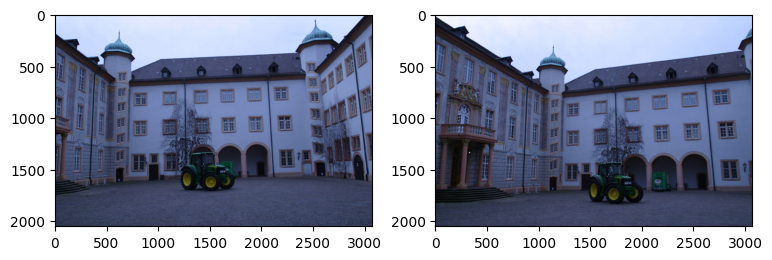

In [109]:
#Reading two images for reference
img1 = cv2.imread("../tutorial/data/castle-P30/images/0001.jpg")
img2 = cv2.imread("../tutorial/data/castle-P30/images/0002.jpg")

#Converting from BGR to RGB format
img1 = img1[:,:,::-1]
img2 = img2[:,:,::-1]

#NOTE: you can adjust appropriate figure size according to the size of your screen
fig,ax=plt.subplots(ncols=2,figsize=(9,4)) 
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [110]:
akaze = cv2.AKAZE_create()

# Detecting keypoints and computing descriptors
kp1, desc1 = akaze.detectAndCompute(img1, None)
kp2, desc2 = akaze.detectAndCompute(img2, None)

# Creating BFMatcher object
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Matching descriptors
matches = matcher.match(desc1, desc2)

#Aligning two keypoint vectors
img1pts,img2pts,img1idx,img2idx=ut.GetAlignedMatchesAKAZE(kp1,kp2,matches)


## 2.2. Fundamental Matrix Computation

### 2.2.1. Eight Point Algorithm

In [111]:
F, maskgt= cv2.findFundamentalMat(img1pts,img2pts, method=cv2.FM_8POINT)

print(F)

[[-2.37289418e-08  2.61848460e-07 -1.00440661e-04]
 [ 2.34659388e-07  2.60676548e-07 -3.06626327e-03]
 [-3.23679414e-04  1.90779920e-03  1.00000000e+00]]


### 2.2.3. with RANSAC (Random Sample Consensus)

In [112]:
F, mask = cv2.findFundamentalMat(img1pts,img2pts,method=cv2.FM_RANSAC,ransacReprojThreshold=0.1)
#mask = maskgt.astype(bool).flatten()

print(F)


[[-7.77567683e-09 -2.56152797e-07  4.11257517e-04]
 [ 7.22731633e-07  7.44202903e-08 -5.85621344e-03]
 [-1.04192931e-03  5.34994561e-03  1.00000000e+00]]


## 2.2. Epipolar Lines Computation

In [113]:
lines2=cv2.computeCorrespondEpilines(img1pts,1,F).reshape(-1,3)
lines1=cv2.computeCorrespondEpilines(img2pts,2,F).reshape(-1,3)


print(lines1)
print(lines2)

[[-6.54549961e-02  9.97855522e-01 -8.39704010e+02]
 [-6.49028925e-02  9.97891585e-01 -8.44149292e+02]
 [-1.00464740e-01  9.94940619e-01 -5.56965116e+02]
 ...
 [-4.17127765e-02  9.99129643e-01 -1.03048803e+03]
 [-8.58158364e-02  9.96311017e-01 -6.75475318e+02]
 [-3.92360184e-02  9.99229971e-01 -1.05034593e+03]]
[[ 3.37655993e-02 -9.99429780e-01  9.49012264e+02]
 [ 3.35580993e-02 -9.99436768e-01  9.53458511e+02]
 [ 4.60102830e-02 -9.98940966e-01  6.86509067e+02]
 ...
 [ 8.13504951e-02 -9.96685556e-01 -7.25310524e+01]
 [ 4.36125990e-02 -9.99048518e-01  7.37930725e+02]
 [ 5.04514052e-02 -9.98726517e-01  5.91237572e+02]]


## 2.3. Epipoles Computation

In [114]:
#to do later..


## 2.4. Visualizations I: Epipolar Geometry
### 2.4.1. Epipolar Lines

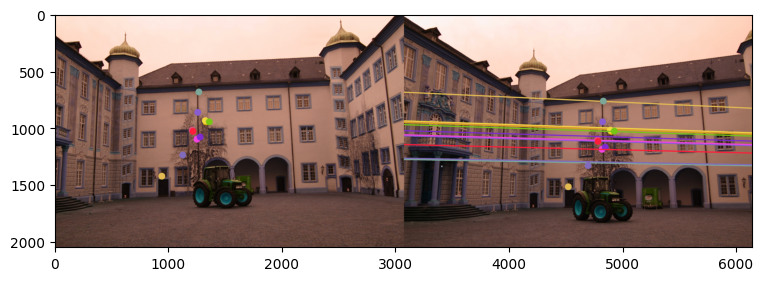

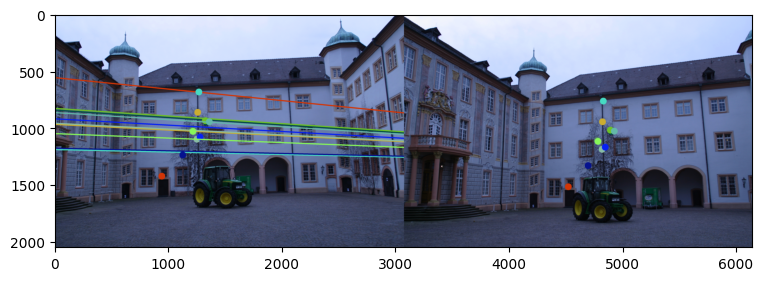

In [115]:

mask=mask.astype(bool).flatten()
tup = ut.drawlines(img2,img1,lines2,img2pts[mask],img1pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines2 = np.concatenate(tup[::-1],axis=1) #reversing the order of left and right images

# Convert the image from BGR to RGB format
epilines2 = cv2.cvtColor(epilines2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(9,4))
plt.imshow(epilines2)
plt.show()


tup = ut.drawlines(img1,img2,lines1,img1pts[mask],img2pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines1 = np.concatenate(tup,axis=1) 

plt.figure(figsize=(9,4))
plt.imshow(epilines1)
plt.show()



### 2.4.2. Epipoles

In [116]:
# to do later..

## 2.5. Pose Estimation

In [117]:
#intrinsic parameter of camera
K = np.array([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])

E = K.T.dot(F.dot(K))

R1,R2,t = sfmnp.ExtractCameraPoses(E)
t = t[:,np.newaxis]

## 2.6. Visualizations II: Camera Poses

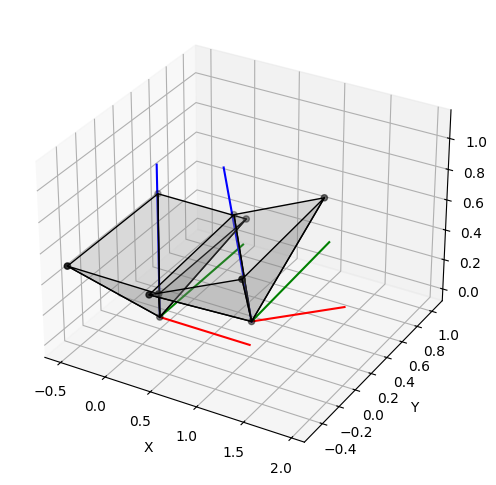

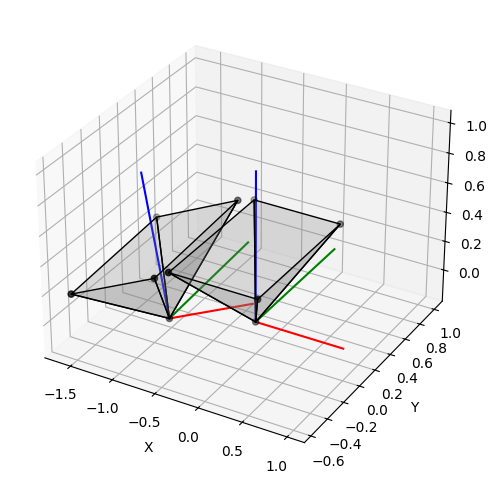

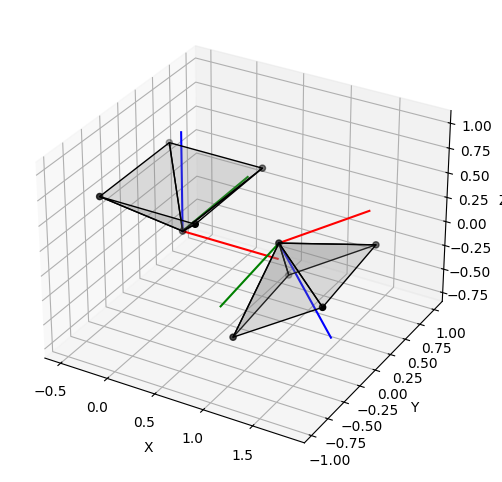

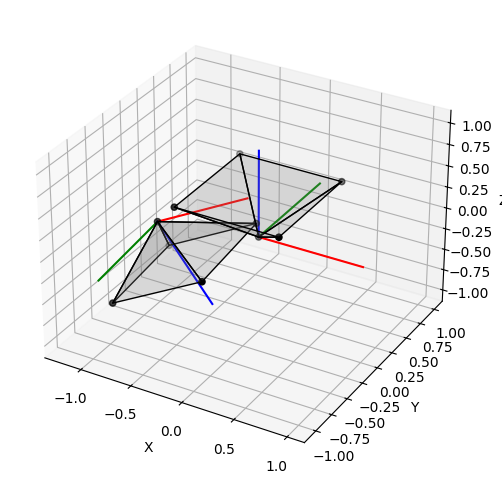

In [118]:
for R_ in [R1,R2]: 
    for t_ in [t,-t]:
        
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
        ut.PlotCamera(R_,t_[:,0],ax)

# Chapter 3. 3D Scene Estimations

## 3.1. Triangulation: DLT Method 

In [119]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t): 
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]
    
    pts4d = cv2.triangulatePoints(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]
    
    return pts3d

In [120]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t)


## 3.2. Visualizing the triangulated points of configurations

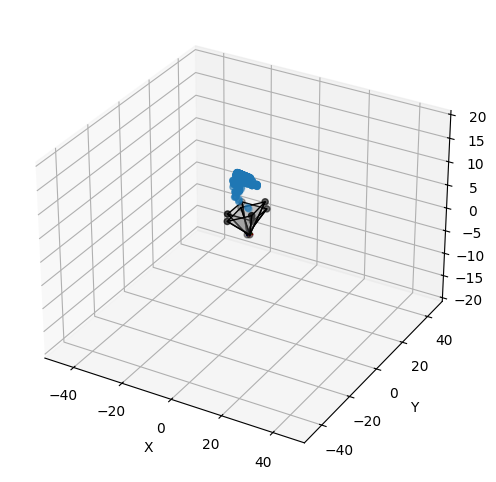

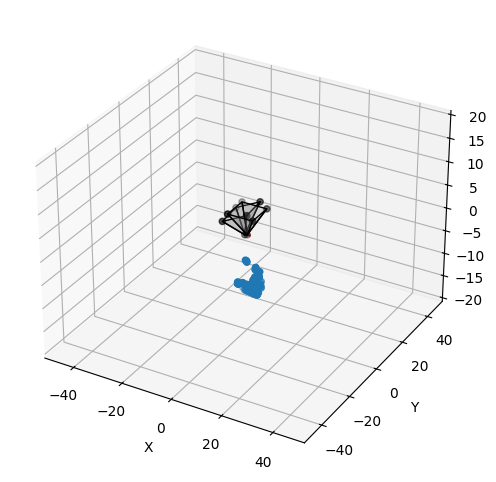

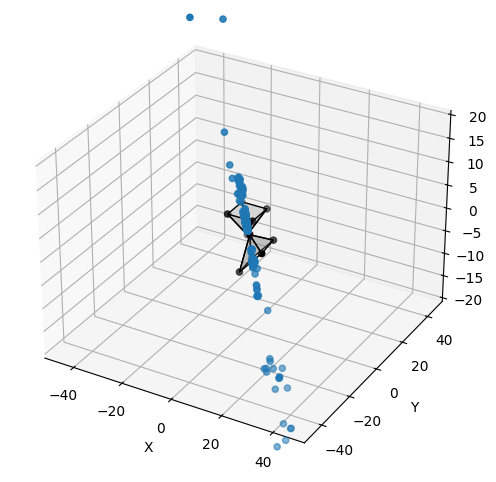

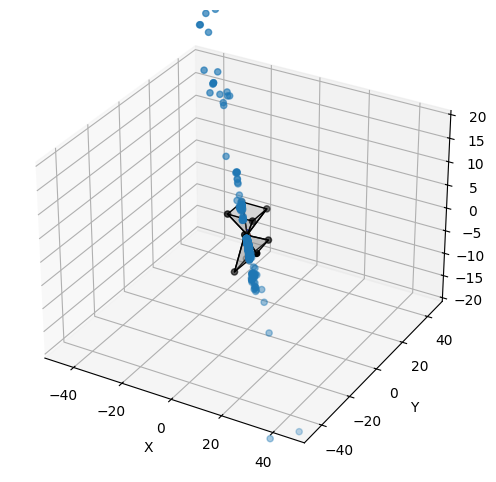

In [121]:
configSet = [None,None,None,None]
configSet[0] = (R1,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,t))
configSet[1] = (R1,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,-t))
configSet[2] = (R2,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t))
configSet[3] = (R2,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,-t))

for cs in configSet: 
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax,scale=5,depth=5)
    ut.PlotCamera(cs[0],cs[1][:,0],ax,scale=5,depth=5)

    pts3d = cs[-1]
    ax.scatter3D(pts3d[:,0],pts3d[:,1],pts3d[:,2])

    ax.set_xlim(left=-50,right=50)
    ax.set_ylim(bottom=-50,top=50)
    ax.set_zlim(bottom=-20,top=20)

## 3.3. Camera Pose Disambiguation

In [122]:
_,R,t,mask2=cv2.recoverPose(E,img1pts[mask],img2pts[mask],K)


## 3.4. Visualizing Point Cloud Output

In [123]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R,t)
ut.pts2ply(pts3d,'castle_2view.ply')

In [124]:
visualize_3d_data=True

if visualize_3d_data:
    import open3d as o3d

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts3d)

    # Create a visualizer object
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=800, height=600)

    # Add the point cloud to the visualizer
    vis.add_geometry(pcd)

    # Start the visualization
    vis.run()

    # Destroy the window after use
    vis.destroy_window()


# 3. Reprojection Error: Evaluation

## 3.1. Computation

In [125]:
def compute_reprojection_error(pts3d, R1, t1, R2, t2, img1pts, img2pts, mask, K):
    # Project the 3D points back to 2D using the rotation and translation matrices
    img1ptsReproj, _ = cv2.projectPoints(pts3d, R1, t1, K, distCoeffs=None)
    img2ptsReproj, _ = cv2.projectPoints(pts3d, R2, t2, K, distCoeffs=None)

    # Reshape the reprojected points
    img1ptsReproj = img1ptsReproj.reshape(-1, 2)
    img2ptsReproj = img2ptsReproj.reshape(-1, 2)

    img1ptsReproj = img1ptsReproj.reshape(-1, 2)
    img2ptsReproj = img2ptsReproj.reshape(-1, 2)

    # Compute the error as the Euclidean distance between the original and reprojected points
    err1 = np.sqrt(np.sum((img1pts[mask] - img1ptsReproj)**2, axis=1)).mean()
    err2 = np.sqrt(np.sum((img2pts[mask] - img2ptsReproj)**2, axis=1)).mean()

    return err1, err2

print(compute_reprojection_error(pts3d,np.eye(3,3),np.zeros((3,1)),R,t,img1pts,img2pts,mask,K))

(0.20435406870190972, 0.20555656411480963)


## 3.2. Visualizations

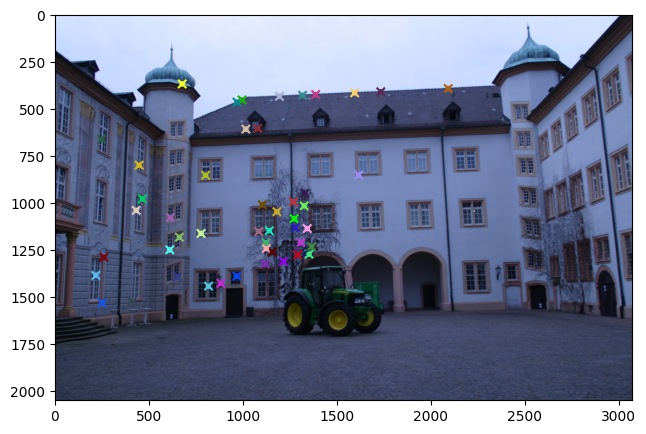

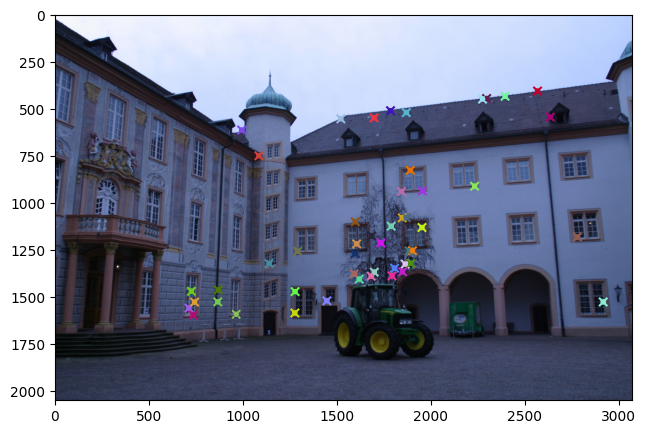

In [126]:
img1ptsReproj, _ = cv2.projectPoints(pts3d,np.eye(3,3),np.zeros((3,1)),K,distCoeffs=None)
img2ptsReproj, _ = cv2.projectPoints(pts3d,R,t,K,distCoeffs=None)

img1ptsReproj = img1ptsReproj.reshape(-1, 2)
img2ptsReproj = img2ptsReproj.reshape(-1, 2)

fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img1,img1pts[mask],img1ptsReproj,ax)

fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img2,img2pts[mask],img2ptsReproj,ax)

# 4. Perspective-n-Point Algorithm: New Camera Registration

## 4.0. Reading third image and 2D-3D Matching using AKAZE

[[200 253   3 ...  71 136  55]
 [ 33  18 108 ... 127 255  52]
 [ 65   9 156 ... 144 255   1]
 ...
 [180  15  82 ... 253 223  26]
 [ 26 238 137 ... 123 255   8]
 [  0 162 133 ... 121 255  60]]
[[200 253   3 ...  71 136  55]
 [ 33  18 108 ... 127 255  53]
 [ 65   9 188 ... 144 255   3]
 ...
 [229   9 122 ... 255 255  63]
 [ 30 252 131 ...   0 200  63]
 [  0 248   1 ...  65 255  63]]
Number of matches with image 1:  437
Number of matches with image 2:  457


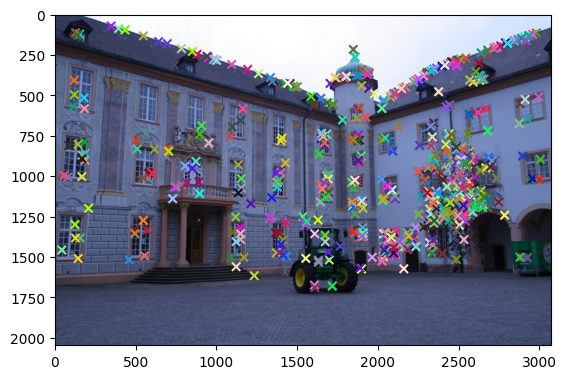

Number of 3D points: 894
Number of 2D points: 894


In [127]:
img3 = cv2.imread("../tutorial/data/castle-P30/images/0005.jpg")
img3 = img3[:,:,::-1]
#akaze= cv2.AKAZE_create()
kp3, desc3 = akaze.detectAndCompute(img3,None)



img3pts,pts3dpts = ut.Find2D3DMatches(desc1,img1idx,desc2,img2idx,desc3,kp3,mask,pts3d)

plt.imshow(img3, cmap='gray')
colors = colors=np.random.rand(len(img3pts),3)
plt.scatter(img3pts[:, 0], img3pts[:, 1],marker='x',c=colors)
plt.show()

print(f"Number of 3D points: {len(pts3dpts)}")
print(f"Number of 2D points: {len(img3pts)}")


# Verify correspondences
# for i in range(10):
#     print(f"2D point: {img3pts[i]}, 3D point: {pts3dpts[i]}")

## 4.1. Perspective-n-Point (PnP) Algorithm

### 4.1.1. Least Squares Solution

### 4.1.2. RANSAC

In [128]:


retval,Rvec,tnew,mask3gt = cv2.solvePnPRansac(pts3dpts,img3pts,K,None,confidence=.99,flags=cv2.SOLVEPNP_ITERATIVE)
Rnew,_=cv2.Rodrigues(Rvec)
print(tnew)
print(Rnew)

if not retval: 
    raise Exception("PnP failed to converge")


[[-3.7262556 ]
 [ 0.20659388]
 [ 1.10725691]]
[[ 0.70368756  0.10939149  0.70203798]
 [-0.10094769  0.99344609 -0.05361378]
 [-0.70330177 -0.03314177  0.71011847]]


In [129]:
Rnew_,tnew_,mask3=sfmnp.LinearPnPRansac(pts3dpts,img3pts,K,outlierThres=5.0,iters=2000)
tnew_ = tnew_.reshape(3,1)
print(tnew_)
print(Rnew_)

[[-1.35464507]
 [ 1.04050335]
 [ 6.51902353]]
[[ 0.05041327  0.74250688  0.66793864]
 [ 0.89231848  0.26690245 -0.36404781]
 [-0.44858246  0.61436684 -0.64909719]]


## 4.2. Visualizations

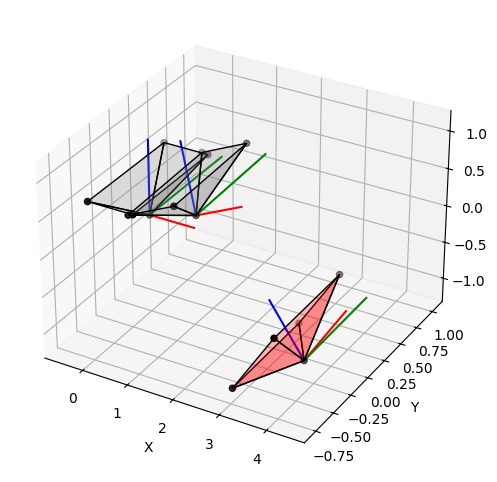

In [130]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')



ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
ut.PlotCamera(R,t[:,0],ax)
ut.PlotCamera(Rnew,tnew[:,0],ax,faceColor='red')

# 5. Re-triangulation

In [131]:
tnew = tnew[:,0]
kpNew, descNew = kp3, desc3 

kpOld,descOld = kp1,desc1
ROld, tOld = np.eye(3), np.zeros((3,1))

accPts = []
for (ROld, tOld, kpOld, descOld) in [(np.eye(3),np.zeros((3,1)), kp1,desc1),(R,t,kp2,desc2)]: 
    
    #Matching between old view and newly registered view.. 
    print ('[Info]: Feature Matching..')
    matcher = cv2.BFMatcher(crossCheck=True)
    matches = matcher.match(descOld, desc3)
    matches = sorted(matches, key = lambda x:x.distance)
    imgOldPts, imgNewPts, _, _ = ut.GetAlignedMatchesAKAZE(kpOld,kpNew,matches)
    
    #Pruning the matches using fundamental matrix..
    print ('[Info]: Pruning the Matches..')
    F,mask=cv2.findFundamentalMat(imgOldPts,imgNewPts,method=cv2.FM_RANSAC, ransacReprojThreshold=0.1, confidence=0.99)
    mask = mask.flatten().astype(bool)
    imgOldPts=imgOldPts[mask]
    imgNewPts=imgNewPts[mask]
    
    #Triangulating new points
    print ('[Info]: Triangulating..')
    
    newPts = sfmnp.GetTriangulatedPts(imgOldPts,imgNewPts, K, Rnew,tnew[:,np.newaxis],cv2.triangulatePoints,ROld,tOld)
    
    #Adding newly triangulated points to the collection
    accPts.append(newPts)

[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)
[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)


In [132]:
#Adding the original 2-view-sfm point cloud and saving the whole collection
accPts.append(pts3d)
accPts = np.array(np.concatenate(accPts,axis=0))
ut.pts2ply(accPts,'castle_nview.ply')

# 6. Final Result 

In [133]:
if visualize_3d_data:
    import open3d as o3d

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(accPts)

    # Create a visualizer object
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=800, height=600)

    # Add the point cloud to the visualizer
    vis.add_geometry(pcd)

    # Start the visualization
    vis.run()

    # Destroy the window after use
    vis.destroy_window()


# Chapter 4. Putting It Together: Part I

# Chapter 5. Bundle Adjustment

# Chapter 6. Putting It Together: Part II